# Implicit representation for mesh reconstruction with Point Clouds

In this lab work we will reconstruct shapes from point sets with and without their normal information.
Each network/method will output the distance or signed distance and one can extract the surface with Marching
cubes, following these steps :
- Use the trained network to compute the values of the signed distance on a grid
- Extract the 0 levelset (marching_cubes method of the mcubes library)
- Save/visualize the mesh (export_obj method of the mcubes library)

In [1]:
!pip install potpourri3d
!pip install git+https://github.com/skoch9/meshplot.git
!pip install pythreejs
!pip install pymcubes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.1/881.1 kB 11.4 MB/s eta 0:00:00
  Cloning https://github.com/skoch9/meshplot.git to /tmp/pip-req-build-8pgchhtd
  Running command git clone --filter=blob:none --quiet https://github.com/skoch9/meshplot.git /tmp/pip-req-build-8pgchhtd
  Resolved https://github.com/skoch9/meshplot.git to commit 725e4a7926a5f10888f0edd1762fecf9db751c56
  Preparing metadata (setup.py) ... done
  Created wheel for meshplot: filename=meshplot-0.3.3-py3-none-any.whl size=21157 sha256=e88dc1e52a235deda56f5bd0b1625ca393575d24f80e90dda14baafe621b07c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-w04fu57a/wheels/52/4c/7f/d5efb36b9456153d4d8d203257dd50d5d2550dde8311cd1d90
Successfully built meshplot
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!wget https://www.lix.polytechnique.fr/~pierson/cours/tp_sdf_material.zip

--2024-11-10 11:05:29--  https://www.lix.polytechnique.fr/~pierson/cours/tp_sdf_material.zip
Resolving www.lix.polytechnique.fr (www.lix.polytechnique.fr)... 193.55.176.29
Connecting to www.lix.polytechnique.fr (www.lix.polytechnique.fr)|193.55.176.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11946957 (11M) [application/zip]
Saving to: ‘tp_sdf_material.zip’

tp_sdf_material.zip 100%[===================>]  11.39M  7.01MB/s    in 1.6s    

2024-11-10 11:05:32 (7.01 MB/s) - ‘tp_sdf_material.zip’ saved [11946957/11946957]



In [3]:
!unzip -o tp_sdf_material.zip
!ls

Archive:  tp_sdf_material.zip
   creating: img/
  inflating: img/TD5_sdf.png         
   creating: mesh_utils/
  inflating: mesh_utils/.DS_Store    
  inflating: mesh_utils/__init__.py  
  inflating: mesh_utils/mesh.py      
  inflating: mesh_utils/geometry.py  
  inflating: mesh_utils/laplacian.py  
  inflating: mesh_utils/file_utils.py  
   creating: plot_utils/
  inflating: plot_utils/.DS_Store    
  inflating: plot_utils/__init__.py  
  inflating: plot_utils/utils.py     
  inflating: plot_utils/plot.py      
   creating: plot_utils/.ipynb_checkpoints/
  inflating: plot_utils/.ipynb_checkpoints/__init__-checkpoint.py  
  inflating: plot_utils/.ipynb_checkpoints/plot-checkpoint.py  
  inflating: armadillo_sub.xyz       
armadillo_sub.xyz  img	mesh_utils  plot_utils	sample_data  tp_sdf_material.zip


In [4]:
from google.colab import output
output.enable_custom_widget_manager()

import numpy as np
import mcubes
import plot_utils as plu
from mesh_utils.mesh import TriMesh
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Traditional reconstruction approach
This method is a "historical" method (<a href="https://dl.acm.org/doi/abs/10.1145/133994.134011">link</a>) for reconstructing a surface from a set of points. It consists in taking an oriented point cloud $(x_i , n_i )$, and estimating for any arbitrary point $x$ in the ambient space a signed distance function as : $u(x) = ± min_i ∥x_i − x∥$

The sign is given by the sign of the scalar product $\langle x - x_i, n_i \rangle$.

The original method starts with unoriented point clouds and devises a clever way to estimate the normal direction and their orientation. Here, for simplicity, we start with oriented points.

In [5]:
def get_pc(path):
    ## Load the oriented point set. You can use the function np.loadtxt
    data=np.loadtxt(path)
    point_cloud=data[:,:3]
    normals=data[:,3:]


    return point_cloud, normals

In [6]:
pc, normals = get_pc("armadillo_sub.xyz")

In [8]:
plu.plot_pc(pc, point_size=2,cmap=normals) #You can put cmap = normals to see normals orientation as color

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0216503…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_2210da81-6a50-4a79-921c-26ce833209c1'.

The second step is to compute the sdf based on the set of points. You will first need to build a grid of points (using e.g. np.meshgrid), and then to compute the sdf to the set of points. Don't forget to adapt the limits of the grid to the size of the point cloud! For the distance, use an efficient way to compute the distance (look at solutions of previous labs to get an idea).

In [9]:
from scipy import spatial
from scipy.spatial import cKDTree
import numpy as np
class KNNSearch():
    DTYPE = np.float32
    NJOBS = 4

    def __init__(self, data):
        self.data = np.asarray(data, dtype=self.DTYPE)
        self.kdtree = cKDTree(self.data)

    def query(self, kpts, k, return_dists=False):
        kpts = np.asarray(kpts, dtype=self.DTYPE)
        nndists, nnindices = self.kdtree.query(kpts, k=k, workers=self.NJOBS)
        if return_dists:
            return nnindices, nndists
        else:
            return nnindices

    def query_ball(self, kpt, radius):
        kpt = np.asarray(kpt, dtype=self.DTYPE)
        assert kpt.ndim == 1
        nnindices = self.kdtree.query_ball_point(kpt, radius, n_jobs=self.NJOBS)
        return nnindices

def compute_nearest_neighbor(X, Y):
    """
    Compute the nearest neighbor in Y for each point in X

    Parameters:
    -----------
    X : (n, d) array of points
    Y : (m, d) array of points

    Returns:
    --------
    nearst_neighbor : (n,) array of indices of the nearest neighbor in Y for X
    """
    # TODO DO NOT USE LOOPS
    querier = KNNSearch(X)
    nn_indices = querier.query(Y, 1)
    return nn_indices

def compute_sdf(point_cloud, normals, points_query):
    ## Compute SDF on points_query from the shape defined by point_cloud and normals
    sdf=np.zeros(len(points_query))
    ind=compute_nearest_neighbor(point_cloud,points_query)
    nearest_normals=normals[ind]
    nearest_points=point_cloud[ind]
    vectors=points_query-nearest_points
    vectors=torch.from_numpy(vectors)
    nearest_normals=torch.from_numpy(nearest_normals)
    signs=torch.sign(torch.einsum('ij,ij->i', vectors, nearest_normals))
    distances = np.linalg.norm(points_query - nearest_points, axis=1)
    distances=torch.from_numpy(distances)
    sdf=distances*signs
    return sdf

def compute_sdf_grid(point_cloud, normals, grid_size=40):
    ## Compute SDF on a XYZ grid. First generate the grid (it has to enclose the point cloud)
    ## Then compute the sdf
    #compute the enclosing grid
    min_bounds = point_cloud.min(axis=0)
    max_bounds = point_cloud.max(axis=0)
    x = np.linspace(min_bounds[0], max_bounds[0], grid_size)
    y = np.linspace(min_bounds[1], max_bounds[1], grid_size)
    z = np.linspace(min_bounds[2], max_bounds[2], grid_size)
    grid_x, grid_y, grid_z = np.meshgrid(x, y, z, indexing="ij")
    grid_points = np.stack([grid_x, grid_y, grid_z], axis=-1).reshape(-1, 3)  # Shape: (grid_size**3, 3)
    sdf=compute_sdf(point_cloud, normals, grid_points)
    sdf=sdf.numpy()
    sdf=sdf.reshape((grid_size,grid_size,grid_size))


    return sdf # shape (grid_size, grid_size, grid_size)

In [10]:
sdf = compute_sdf_grid(pc, normals)
print(sdf.shape)

(40, 40, 40)


In [11]:
vertices, triangles = mcubes.marching_cubes(sdf,0)
mesh = TriMesh(vertices, triangles)
mcubes.export_obj(vertices, triangles, 'result_hoppe.obj')
plu.plot(mesh)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(19.526107…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_bef306d9-80a4-489f-aa43-aed56fe2db71'.

You can try different grid sizes, but do not increase too much its size to avoid memory issues

# DeepSDF

This method (see <a href="https://arxiv.org/pdf/1901.05103">link</a>) consists of representing the SDF as a function (x, y, z) -> sdf, parameterized by a neural network.

We first build the network according to the following figure

![title](img/TD5_sdf.png)

The activations are ReLUs, except for the last one, defined as $\phi(a) = \text{tanh}(a)$.

Moreover, the networks have specific initialization (**except the last one**): the weights of size $n \times n$ are initialized according to the following $\mathcal{N}\left(0, \sqrt{\frac{2}{n}}\right)$ law, and the bias are initalized to 0 (except for the last linear layer). You can access to a Linear layer weight, and bias via layer..weight.data, and layer.bias.data, or use <a href="https://pytorch.org/docs/stable/nn.init.html">nn.init<a> on layer.weight, layer.bias

In [12]:
def custom_init(m):

    if isinstance(m, nn.Linear):

        n = m.weight.size(0)


        nn.init.normal_(m.weight, mean=0, std=(2/n)**0.5)


        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


In [19]:
class SDFNet(nn.Module):
    def __init__(self, ninputchannels, dropout=0.2, gamma=0, sal_init=False, eik=False):
        super(SDFNet, self).__init__()
        ## Prepare the layers
        ## Don't forget to initialize your weights correctly.

        ## gamma, sal_init, eik are for later
        self.gamma=gamma
        self.eik = eik
        self.layers=nn.ModuleList()
        for i in range(7):
          if i==0:
            self.layers.append(nn.Linear(ninputchannels,512))
          elif i==4:
            self.layers.append(nn.Linear(ninputchannels+512,512))
          else:

            self.layers.append(nn.Linear(512, 512))  # Example layer dimensions
        self.last_layer = nn.Linear(512, 1)

        self.layers.apply(custom_init)





    def forward(self,x):
        ## Logic of the neural network
        ## You can add dropout if you want
        x0=x
        for i in range(len(self.layers)):
          if i==4:
            x=torch.cat((x0,x),dim=1)

          x = self.layers[i](x)
          x = torch.relu(x)
        x = self.last_layer(x)
        x=torch.tanh(x)

        return x

### Loss function

The loss is computed by sampling random points in the ambient space (set X), computing their ground truth SDF (using part one), and computing the distance between computed and ground truth sdf:

$$
\mathcal{L}(\theta) = \mathbb{E}_{x \sim X} [|\text{clamp}(u_\theta(x), \delta) - \text{clamp}(\text{SDF}_{\text{gt}}(x), \delta)|]
$$

where $\text{clamp}(x, \delta) := \min(\delta, \max(−\delta, x))$ (you can use torch.clamp). To understand the signification of parameter $\delta$, read carefully paragraph 3 of the paper.

In [13]:
def evaluate_loss(net, pts_gt, sdf_gt, device, lpc, batch_size=2000, delta = 0.1):
    ## For this function, you need to sample batch_size number of points
    ## From pts_gt. Evaluate the sdf at those points and compute the loss
    ## compared to sdf_gt (be careful to select the same points between pts_gt and sdf_gt)
    pts_gt,sdf_gt=pts_gt.to(device),sdf_gt.to(device)
    indices=torch.randperm(pts_gt.size(0))[:batch_size]


    # Select points
    sampled_pts=pts_gt[indices]
    sampled_sdf_gt=sdf_gt[indices]
    sampled_pts = sampled_pts.to(device)
    predicted_sdf = net(sampled_pts).squeeze()
    predicted_sdf=predicted_sdf.clamp(min=0,max=delta)
    sampled_sdf_gt=sampled_sdf_gt.clamp(min=0,max=delta)


    # compute and store the losses
    loss = torch.mean(torch.abs(sampled_sdf_gt-predicted_sdf),axis=0)

    # append all the losses
    lpc.append(float(loss.item()))

    return loss

### Training the SDF

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_normalized_pointcloud(point_cloud, margin=0.05):
    ## Return the same point cloud, scaled such that
    ## x,y,z values are between -1+margin and 1-margin
    #compute the enclosing grid
    min_bound=np.min(point_cloud,axis=0)
    max_bound=np.max(point_cloud,axis=0)
    center=(min_bound+max_bound)/2
    centered_points=point_cloud-center
    scale=(1-margin)/(max_bound-min_bound).max()*2
    pc_normed=centered_points*scale

    #normalize the points
    return pc_normed

def compute_gt_sdf(point_cloud, normals, n_points=1000000):
    ## Sample a n_points points in with XYZ coordinates between -1 and 1
    ## Then use compute_sdf to get sdf_gt

    p_norm = get_normalized_pointcloud(point_cloud, margin=0.00001)
    sampled_pts=2*torch.rand(n_points,3)-1
    #preparing gt points:




    gtp = sampled_pts.numpy()

    sdf_gt = compute_sdf(p_norm, normals, gtp)
    sdf_gt=sdf_gt.numpy()
    return sdf_gt, gtp

In [15]:
n_points = 100000
sdf_gt, gtp = compute_gt_sdf(pc, normals, n_points)

In [16]:
print(device)
print(sdf_gt.shape, gtp.shape) ## Should be same shape
print(np.isclose(gtp.max(), 1, 1e-3), np.isclose(gtp.min(), -1, 1e-3)) ## Should be equal to one

cuda
(100000,) (100000, 3)
True True


In [17]:
def training_sdf(sdf_gt, gtp):
    geomnet = SDFNet(3)
    geomnet.to(device)
    gtpoints = torch.from_numpy(gtp).float().to(device)
    gtsdf = torch.from_numpy(sdf_gt).float().to(device)

    lpc = []

    optim = torch.optim.Adam(params = geomnet.parameters(), lr=1e-5)

    nepochs=10000
    pbar = tqdm(total=nepochs,
                desc="Training")

    for epoch in range(nepochs):
        loss = evaluate_loss(geomnet, gtpoints, gtsdf, device, lpc, delta = 0.1, batch_size=2500)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if epoch % 100 == 0:
        #     print(f"Epoch {epoch}/{nepochs} - loss : {loss.item()}")
            pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)
    return lpc, geomnet


In [20]:
loss_, net_sdf = training_sdf(sdf_gt, gtp)
## If the training is slow (hours), change you execution environment to GPU!

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

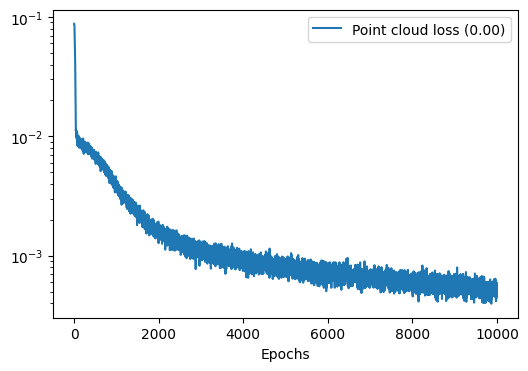

In [21]:
# Check that the network learned something
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(loss_, label = 'Point cloud loss ({:.2f})'.format(loss_[-1]))
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Reconstruct the shape
Code the function compute_deepsdf that compute sdf on a grid using a trained sdf network

In [22]:
def compute_deepsdf(net, grid_size=40):
    net.eval()
    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1,1, grid_size)
    z = np.linspace(-1,1, grid_size)
    grid_x, grid_y, grid_z = np.meshgrid(x, y, z, indexing="ij")
    grid_points = np.stack([grid_x, grid_y, grid_z], axis=-1).reshape(-1, 3)



    v = grid_points# point cloud definition (more than one_line, reshape it to (something, 3))
    queries = torch.from_numpy(v).float().to(device)
    with torch.no_grad():
        distance = net(queries).detach().cpu().numpy()
    u = np.reshape(distance,(grid_size,grid_size,grid_size))
    return u

In [23]:
u = compute_deepsdf(net_sdf, 40)
vertices, triangles = mcubes.marching_cubes(u,0)
mesh = TriMesh(vertices, triangles)
mcubes.export_obj(vertices, triangles, 'result_deepsdf.obj')
plu.plot(mesh)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(19.521935…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_37e583f3-c979-4f27-adb8-952e10eb5d25'.

# Unsigned Distance Function

In this case (paper <a href="https://arxiv.org/pdf/1911.10414">link</a>), the objective is to learn directly on raw point clouds, without pre-processing to predicts normals/orientation of the shape. To reach this objective, the authors notice the following:
- Using the usigned distance function (absolute value of the predicted SDF) is then necessary
- Carefully choosing the points where to predict the distance is crucial
- Weights initialization is to be changed

The modification to SDF is simple : the loss is now computed by sampling points around each data point $x_i$ , following a centered Gaussian distribution of variance $\sigma²$:

$$
\mathcal{L}(\theta) = \sum_i \mathbb{E}_{x \sim \mathcal{N}(x_i, \sigma^2)}[(|u_{\theta}(x)| - |\text{SDF}_{\text{GT}}](x)|)^2)]
$$

where $\sigma$ is a parameter that you can play with, and $\text{SDF}_{\text{GT}}(x)$ is simply $\text{dist}(x_i, x)$.

The last linear layer is now initialized too, with weights following $\mathcal{N}\left(0, 2\sqrt{\pi}\right)$ law and bias initialized to -1. The last layer activation is now $\phi(a) = \text{tanh}(a) + \gamma a$. Gamma parameter now equals to 0.5.

## Neural network
- Modify SDFNet with sal_init, such that when sal_init=True, the last layer is initialized properly
- Take in account gamma parameter in the network logic

In [24]:
def custom_init_last_layer(m):

    if isinstance(m, nn.Linear):

        n = m.weight.size(0)


        nn.init.normal_(m.weight, mean=0, std=2*(np.pi)**0.5)


        if m.bias is not None:
            nn.init.constant_(m.bias, -1)

In [25]:
class SDFNet(nn.Module):
    def __init__(self, ninputchannels, dropout=0.2, gamma=0, sal_init=False, eik=False):
        super(SDFNet, self).__init__()
        ## Prepare the layers
        ## Don't forget to initialize your weights correctly.

        ## gamma, sal_init, eik are for later
        self.gamma=gamma
        self.eik = eik
        self.sal_init=sal_init
        self.layers=nn.ModuleList()
        for i in range(7):
          if i==0:
            self.layers.append(nn.Linear(ninputchannels,512))
          elif i==4:
            self.layers.append(nn.Linear(ninputchannels+512,512))
          else:

            self.layers.append(nn.Linear(512, 512))  # Example layer dimensions
        self.last_layer = nn.Linear(512, 1)

        self.layers.apply(custom_init)
        if self.sal_init:
          self.last_layer.apply(custom_init_last_layer)





    def forward(self,x):
        ## Logic of the neural network
        ## You can add dropout if you want
        x0=x
        for i in range(len(self.layers)):
          if i==4:
            x=torch.cat((x0,x),dim=1)

          x = self.layers[i](x)
          x = torch.relu(x)
        x = self.last_layer(x)
        if self.sal_init:
          x=torch.tanh(x)+self.gamma*x
        else:
          x=torch.tanh(x)

        return x

## Loss function
Implement the SAL loss function

In [61]:
def evaluate_loss_sal(net, p, sigma, device, losses,batch_size=5000):
    ## Sample batch_size points, and then sample a random point around each point
    p=p.to(device)
    indices=torch.randperm(p.size(0))[:batch_size]
    indices=indices.detach().cpu().numpy()
    p=p.detach().cpu().numpy()
    sampled_pts=np.array([np.random.normal(center,sigma) for center in p[indices]])
    sampled_pts=torch.from_numpy(sampled_pts).float()
    sampled_pts = sampled_pts.to(device)

    predicted_sdf = net(sampled_pts).squeeze()
    p=torch.from_numpy(p).float().to(device)
    true_sdf=torch.norm(sampled_pts-p[indices],dim=1)**2












    # evaluate distances and compute the loss
    # compute and store the losses
    loss = torch.sum((torch.abs(predicted_sdf)-torch.abs(true_sdf))**2,axis=0)
    losses.append(loss.item())

    return loss

In [33]:
def training_sal(point_cloud, loss_function, sigma=0.02):
    geomnet = SDFNet(3, gamma=0.5, sal_init=True)
    geomnet.to(device)

    pc_norm = get_normalized_pointcloud(point_cloud)
    points_torch = torch.from_numpy(pc_norm).float().to(device)

    lpc = []

    optim = torch.optim.Adam(params = geomnet.parameters(), lr=1e-4)

    nepochs=5000
    pbar = tqdm(total=nepochs,
                desc="Training")

    for epoch in range(nepochs):
        loss = loss_function(geomnet, points_torch, sigma, device, lpc, batch_size=5000)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if epoch % 100 == 0:
        #     print(f"Epoch {epoch}/{nepochs} - loss : {loss.item()}")
            pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)


    return lpc, geomnet

In [62]:
# If you get an error: did you modify SDFNet according to the instructions?
loss_sal, net_sal = training_sal(pc, evaluate_loss_sal, sigma=0.02)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (25000) must match the size of tensor b (5000) at non-singleton dimension 0

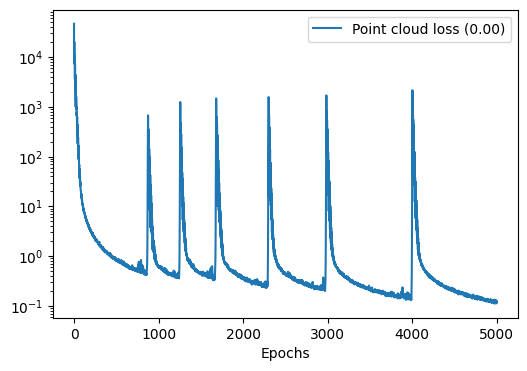

In [35]:
# Check that the network learned something
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(loss_sal, label = 'Point cloud loss ({:.2f})'.format(loss_[-1]))
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [36]:
u = compute_deepsdf(net_sal, 40)
vertices, triangles = mcubes.marching_cubes(u,0)
mesh = TriMesh(vertices, triangles)
plu.plot(mesh)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(19.5, 19.…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_46666be2-1418-4ed8-b996-abee0b9c9631'.

The produced signed distances using the proposed are too smooth and can't overfit a single shape. Therefore, the authors propose to learn the $L_0$ unsigned distance, by minimizing:

$$
\mathcal{L}(\theta) = \sum_i \mathbb{E}_{x \sim \mathcal{N}(x_i, \sigma^2)}[||u_{\theta}(x)| - 1|] + \mathbb{E}_{x \in \mathcal{X}}[|u_{\theta}(x)|],
$$

i.e. we want the distance to be $1$ outside of the surface, and $0$ on the surface.

Write the function evaluate_loss_sal_l0 below accordingly, and launch a new training to see the effects on the results.

In [55]:
def evaluate_loss_sal_l0(net, p, sigma, device, losses,batch_size=5000):
    ## Do the sampling and evaluations
    p=p.to(device)
    indices=torch.randperm(p.size(0))[:batch_size]
    indices=indices.detach().cpu().numpy()
    p=p.detach().cpu().numpy()
    sampled_pts=np.array([np.random.normal(center,sigma,(20, 3)) for center in p[indices]])
    sampled_pts=torch.from_numpy(sampled_pts).float()
    sampled_pts = sampled_pts.to(device)
    p=torch.from_numpy(p).float().to(device)
    sampled_pts_flat = sampled_pts.view(-1, 3)
    predicted_sdf_normal = net(sampled_pts_flat).squeeze().view(batch_size, 20)
    predicted_sdf=net(p[indices]).squeeze()


    # compute and store the losses

    loss =torch.sum(torch.mean(torch.abs(torch.abs(predicted_sdf_normal)-1)))+torch.mean(torch.abs(predicted_sdf))

    losses.append(loss.item())

    return loss

In [56]:
loss_sal_0, net_sal_0 = training_sal(pc, evaluate_loss_sal_l0, sigma=0.02)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

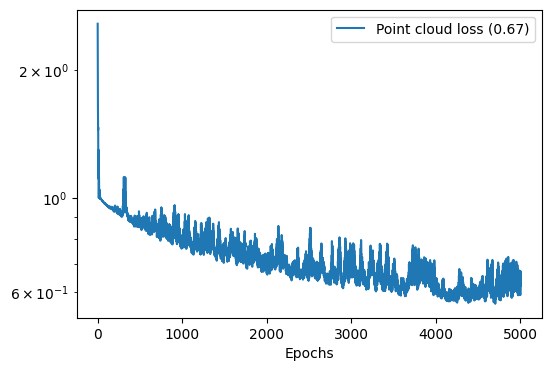

In [57]:
# Check that the network learned something
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(loss_sal_0, label = 'Point cloud loss ({:.2f})'.format(loss_sal_0[-1]))
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [58]:
u = compute_deepsdf(net_sal_0, 40)
vertices, triangles = mcubes.marching_cubes(u,0)
mesh = TriMesh(vertices, triangles)
plu.plot(mesh)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(19.5, 19.…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_8447c5cf-7ce9-4a2e-bac3-eeade528cbdd'.

You can play with the sigma parameter to improve the results (see the paper to choose it wisely).